# 3. Linear Models for Regression

## 3.1. Linear Basis Function Models

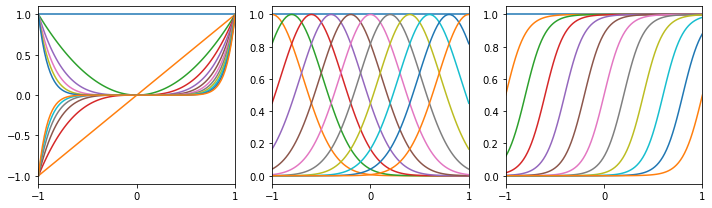

In [1]:
import numpy as np
from base_module import *
import matplotlib.pyplot as plt
%matplotlib inline

deg = 11

x = np.linspace(-1,1,100)
polynomial_basis = Poly_Feature(deg).transform(x)
gaussian_basis = Gaussian_Feature(np.linspace(-1,1,deg),0.1).transform(x)
sigmoid_basis = Sigmoid_Feature(np.linspace(-1,1,deg),0.1).transform(x)

fig = plt.figure(figsize=(10, 3))
for i,basis in enumerate([polynomial_basis,gaussian_basis,sigmoid_basis],1):
    fig.add_subplot(1,3,i)
    for col in range(deg+1):
        plt.plot(x,basis[:,col])
        plt.xlim([-1,1])
        plt.xticks([-1,0,1])

plt.tight_layout()
plt.show()

## 3.2. The Bias-Variance Decomposition

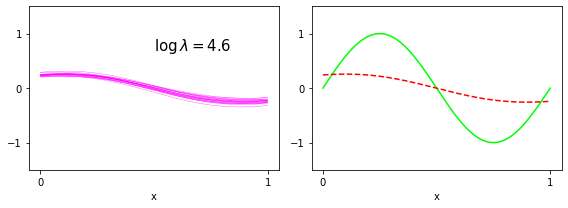

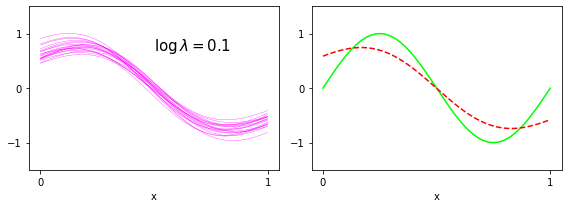

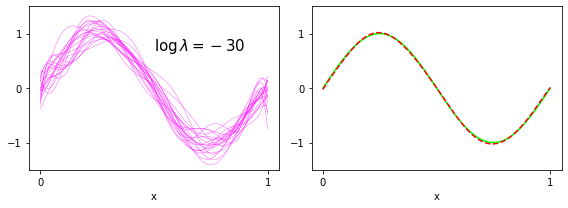

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fitting.bayesian_regression import Bayesian_Regression
from base_module import *

def func(x):
    return np.sin(2 * np.pi * x)

def create_noise_data(function,sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = function(x) + np.random.normal(scale=std, size=x.shape)
    return x, t


# test data
test_x = np.linspace(0, 1, 200)
test_y = func(test_x)
feature = Gaussian_Feature(np.linspace(0, 1, 24), 0.1)
X_test = feature.transform(test_x)



plt.close()
for i,lamda in enumerate([1e+2, np.e**(0.1), np.e**(-30)]):
    fig = plt.figure(figsize=(8, 3.))
    ax = fig.add_subplot(1,2,1)
    ax.text(0.5, 0.7, r"$\log \,\lambda={:.2g}$".format(np.log(lamda)),fontsize=15)
    predict_list = []
    for n in range(100):
        train_x,train_y = create_noise_data(func,25,0.25)
        X_train = feature.transform(train_x)
        model = Bayesian_Regression(alpha=lamda,beta=1.)
        model.fit(X_train,train_y)
        y_mean = model.predict(X_test)
        if n < 20:
            ax.plot(test_x,y_mean,color='magenta',linewidth=0.3)
            ax.set_xlabel("x")
        ax.set_ylim([-1.5,1.5])
        plt.xticks([0,1])
        plt.yticks([-1,0,1])
        predict_list.append(y_mean)
    ax = fig.add_subplot(1,2,2)
    ax.plot(test_x,test_y,color='lime')
    ax.plot(test_x,np.array(predict_list).mean(axis=0),color='red',linestyle='dashed')
    ax.set_xlabel("x")
    ax.set_ylim([-1.5,1.5])
    plt.xticks([0,1])
    plt.yticks([-1,0,1])
    plt.tight_layout()
plt.show()

## 3.3.2 Predictive distribution

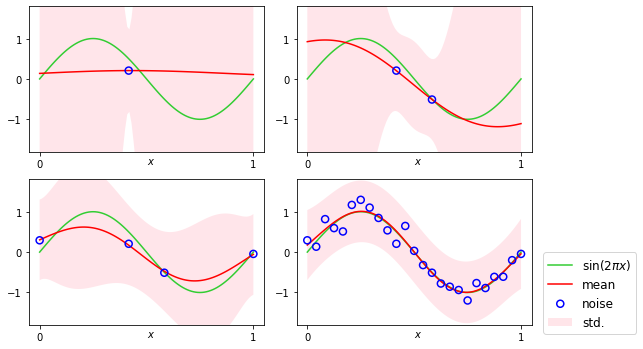

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from base_module import Gaussian_Feature
from fitting.bayesian_regression import Bayesian_Regression

M = 9

def func(x):
    return np.sin(2 * np.pi * x)

def generate_noise_data(func,noise_NUM,std_dev):
    x_n = np.linspace(0,1,noise_NUM)
    np.random.shuffle(x_n)
    t_n = func(x_n) + np.random.normal(scale=std_dev,size=noise_NUM)
    return x_n,t_n

# Create the training data
train_x,train_y = generate_noise_data(func,25,0.2)
feature = Gaussian_Feature(np.linspace(0, 1, M), 0.1)
X_train = feature.transform(train_x)

# Create the test data
test_x = np.arange(0, 1.01, 0.01)
X_test = feature.transform(test_x)
test_y = func(test_x)


'''----Bayesian Regression----'''
model = Bayesian_Regression(alpha=5e-3,beta=2.)


fig = plt.figure(figsize=(9, 5))
idx = [[10],[10,14],[0,10,14,24],list(np.arange(25))]
for i,noise_num in enumerate([1,2,4,25],1):
    model.fit(X_train[0:noise_num,:],train_y[0:noise_num])
    y_mean,y_std = model.predict(X_test,get_std=True)
    ax = fig.add_subplot(2,2,i)
    plt.scatter(train_x[0:noise_num],train_y[0:noise_num],facecolor="none", edgecolor="b",label="noise",s=50,linewidth=1.5,zorder=3)
    plt.plot(test_x,test_y,color='limegreen',label="$\sin(2\pi x)$",zorder=1)
    plt.plot(test_x,y_mean,color='red',label="mean",zorder=2)
    plt.fill_between(test_x, y_mean + y_std, y_mean - y_std, facecolor='pink',alpha=0.4,label="std.")
    ax.text(0.5,-2.1,r"$x$")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.8, 1.8)
    plt.xticks([0,1])
    plt.yticks([-1,0,1])

# config for drawing
plt.subplots_adjust(right=0.75)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0, fontsize=12)
plt.tight_layout()
plt.show()


## Equivalent kernel

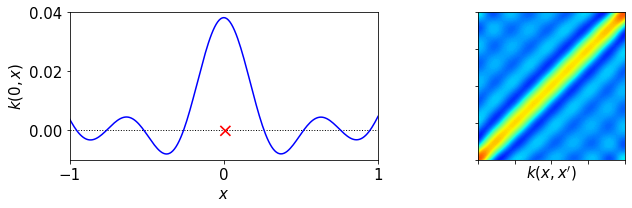

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from fitting.bayesian_regression import Bayesian_Regression
from base_module import *

Font_size = 15
M = 20
feature = Gaussian_Feature(np.linspace(-1.,1.,M),0.1)
model = Bayesian_Regression(beta=10)


def kernel_function(train_x,test_x):
    X_test = feature.transform(test_x)
    model.fit(X_test,np.zeros(len(test_x)))
    phi1 = feature.transform(train_x)
    phi2 = feature.transform(test_x)
    return model.beta * np.sum(phi1 * (model.w_cov @ phi2.T).T,axis=1)


# test data & dummy training data
x = np.arange(-1.01, 1.01, 0.01)
train_x = np.zeros(len(x))
y = kernel_function(train_x,x)


#plotting kernel function
plt.close('all')
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,2,1)
ax.plot(x,y,color='b')
plt.xlabel(r"$x$",fontsize=Font_size)
plt.ylabel(r"$k(0,x)$",fontsize=Font_size)
plt.xticks([-1,0,1],fontsize=Font_size)
plt.yticks([0,0.02,0.04],fontsize=Font_size)
plt.xlim(-1,1)
plt.ylim(-0.01,0.04)
plt.hlines([0], -1, 1, "black", linestyles='dotted',linewidth=1)
plt.text(0,0,r"$\times$", size = 20, color = "red",horizontalalignment="center", verticalalignment='center')

# drawing kernel 2D function
X,Y = np.meshgrid(np.linspace(-1.1,1.1,100),np.linspace(-1.1,1.1,100))
Z = kernel_function(X.ravel(),Y.ravel())
ax = fig.add_subplot(1,2,2)
ax.contourf(X,Y,Z.reshape(X.shape),levels=np.linspace(min(Z),max(Z)/2.7,200),cmap='jet')
ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
ax.set_aspect('equal')
plt.xlabel(r"$k(x,x')$",fontsize=Font_size)
plt.xlim(-1.,1.)
plt.ylim(-1.,1.)
plt.subplots_adjust(wspace=1.5)
plt.tight_layout()
plt.show()

## 3.5.1 Evaluation of the evidence function

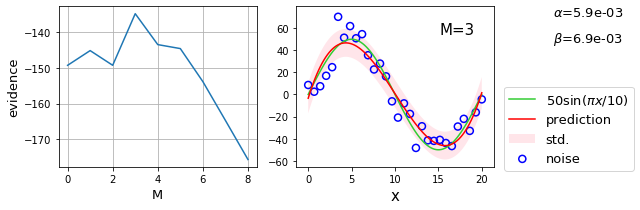

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from fitting.optimal_bayesian_regression import Optimal_Bayesian_Regression
from base_module import *

Font_size = 13
noise_NUM = 30
max_M = 8

def func(x):
    return 50 * np.sin(0.1 * np.pi * x)

#Generating Noise data
def generate_noise_data(func,noise_NUM,std_dev,margin=[0,1]):
    x_n = np.linspace(margin[0],margin[1],noise_NUM)
    np.random.shuffle(x_n)
    t_n = func(x_n) + np.random.normal(scale=std_dev,size=x_n.shape)
    return x_n,t_n


#----training data----
train_x,train_y = generate_noise_data(func,noise_NUM,10,[0,20])
evidence_List = []
model_List = []

# parameter estimation
for m in range(max_M+1):
    model = Optimal_Bayesian_Regression(alpha=100,beta=100)
    feature = Poly_Feature(m)
    X_train = feature.transform(train_x)
    model.fit(X_train,train_y)
    evidence_List.append(model.evidence_function(X_train,train_y))
    model_List.append(model)

#----test data----
deg_index = np.argmax(evidence_List)
optimal_model = model_List[deg_index]
test_x = np.linspace(0,20,100)
X_test = Poly_Feature(deg_index).transform(test_x)
y_mean,y_std = optimal_model.predict(X_test,get_std=True)



# plot log evidence
fig = plt.figure(figsize=(9,3.0))
plt.subplot(1,2,1)
plt.grid()
plt.subplots_adjust(right=0.8)
plt.plot(np.arange(max_M+1),np.array(evidence_List))
plt.xlabel("M",fontsize=Font_size)
plt.ylabel("evidence",fontsize=Font_size)

# plot test data
ax=fig.add_subplot(1,2,2)
ax.plot(test_x,func(test_x),color='limegreen',label="$50\sin(\pi x/10)$")
ax.plot(test_x,y_mean,color='red',label="prediction")
ax.fill_between(test_x,y_mean+y_std,y_mean-y_std,facecolor='pink',alpha=0.4,label="std.")
ax.scatter(train_x,train_y,facecolor="none",edgecolor="b",label="noise",s=50,linewidth=1.5)
ax.legend(bbox_to_anchor=(1.05,0.5),loc='upper left',borderaxespad=0,fontsize=Font_size)
ax.text(0.9,0.9,"M={}".format(deg_index),ha='right',va='top',transform=ax.transAxes,fontsize=15)
ax.text(1.65,1,r"$\alpha$={:.1e}".format(optimal_model.alpha),ha='right',va='top',transform=ax.transAxes,fontsize=Font_size)
ax.text(1.65,0.85,r"$\beta$={:.1e}".format(optimal_model.beta),ha='right',va='top',transform=ax.transAxes,fontsize=Font_size)
plt.tight_layout()
plt.xlabel("x",fontsize=15)
plt.show()